# Ernesto Antonio Reyes Ramírez

# Visión Computacional

# Tarea 6

In [250]:
#Librerias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
from skimage.metrics import peak_signal_noise_ratio as PSNR

### 1. Implementacion de los operados básicos.

Fordward derivative x

In [90]:
def forward_derivative_x(imagen):
    alto, ancho, canales = imagen.shape
    D = np.zeros((alto, ancho, canales))
    
    D[:, :-1 , :] = imagen[:, 1: , :] - imagen[:, :-1 , :]
    
    return D

Fordward derivative y

In [102]:
def forward_derivative_y(imagen):
    alto, ancho, canales = imagen.shape
    D = np.zeros((alto, ancho, canales))
    
    D[:-1, :, :] = imagen[1:, : , :] - imagen[:-1, : , :]
    
    return D

Backward derivative x

In [96]:
def backward_derivative_x(imagen):
    alto, ancho, canales = imagen.shape
    D = np.zeros((alto, ancho, canales))
    
    D[:, 1: , :] = imagen[:, 1: , :] - imagen[:, :-1 , :]
    
    return D

Backward derivative y

In [103]:
def backward_derivative_y(imagen):
    alto, ancho, canales = imagen.shape
    D = np.zeros((alto, ancho, canales))
    
    D[1:, :, :] = imagen[1:, : , :] - imagen[:-1, : , :]
    
    return D

Probamos cada una de las derivadas

In [321]:
img = cv2.imread("img1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [322]:
fwdx = forward_derivative_x(img)

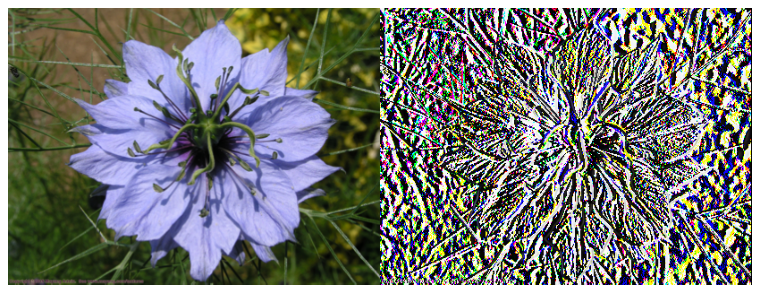

In [323]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,np.array(fwdx,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [327]:
fwdy = forward_derivative_y(img)

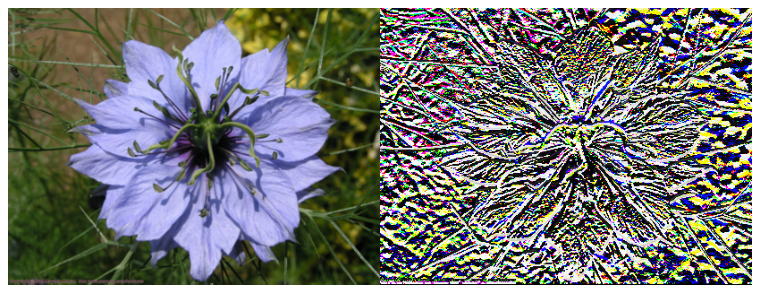

In [328]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,np.array(fwdy,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [329]:
bwdx = backward_derivative_x(img)

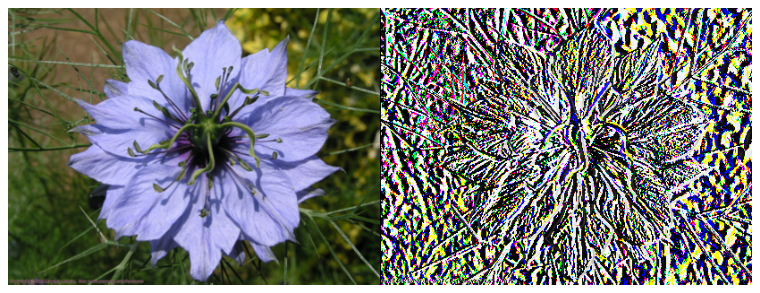

In [330]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,np.array(bwdx,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [331]:
bwdy = backward_derivative_y(img)

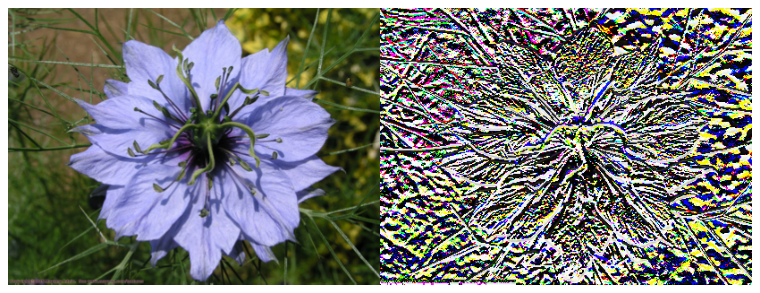

In [332]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,np.array(bwdy,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

Definimos los operadores de gradiente y divergencia

In [98]:
def gradient(img):

    rdim, cdim, ch = img.shape
    
    dx = forward_derivative_x(img)
    dy = forward_derivative_y(img)
    
    dx = dx.reshape((rdim, cdim, ch, 1))
    dy = dy.reshape((rdim, cdim, ch, 1))
    
    grad = np.concatenate((dx,dy), axis = 3)
    
    return grad

def divergence(V):

    dx = backward_derivative_x(V[:,:,:,0])
    dy = backward_derivative_y(V[:,:,:,1])
    
    return dx + dy

In [324]:
g = gradient(img)

In [325]:
div = divergence(g)

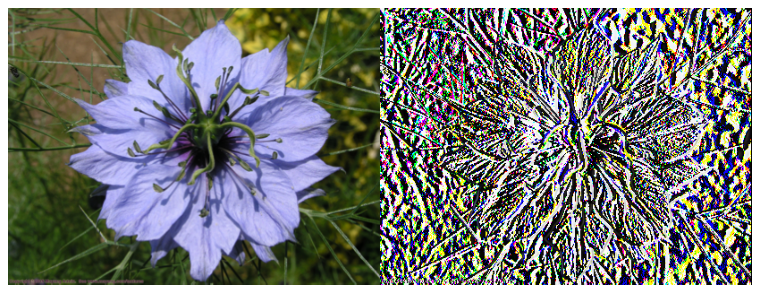

In [326]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,np.array(fwdx,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

### 2. Eliminación de ruido y desenfoque juntas

In [289]:
def fast_gaussian_convolution(u,sigma):

    gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
    gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)
    gaussian_kernel_2d = np.matmul(gaussian_kernel_1d_1,np.transpose(gaussian_kernel_1d_2))
    gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)

    return np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fft2(u)*np.fft.fft2(gaussian_kernel_2d))))

In [290]:
#Fast gaussian convolution para imagenes a color
def FGC_color(u,sigma):
    M, N, C = u.shape
    
    F = np.zeros((M,N,C))
    
    for c in range(C):
        F[:,:,c] = fast_gaussian_convolution(u[:,:,c],sigma)
        
    return F

In [291]:
def MSE(u,v):
    M,N,C = u.shape
    w = (u - v)**2
    e = np.mean(w)
    return e

In [292]:
def norma(u):
    norm = np.square(u)
    norm = np.sum(norm)
    norm = np.sqrt(norm)
    return norm

In [302]:
def deblurring_denoising(u , gamma, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 1000):
    u0 = u
    u1 = u
    
    for k in range(K):
        A = FGC_color(u0,2.0)
        A = FGC_color(A-u,2.0)
        
        grad = gradient(u0)
        norm = norma(grad)
        den = np.sqrt(norm**2 + eta)
        grad = grad/den
        div = divergence(grad)
        
        u1 = u0 - alpha*(A - gamma*div)
        
        if np.sqrt(MSE(u1,u0)) < eps:
            break
        
        u0 = u1
        
    return u1

In [294]:
img1_deg = cv2.imread("img1_degradation1.png")
img1_deg = cv2.cvtColor(img1_deg, cv2.COLOR_BGR2RGB)

In [278]:
d1 = deblurring_denoising(img1_deg, gamma = 0, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 15000)

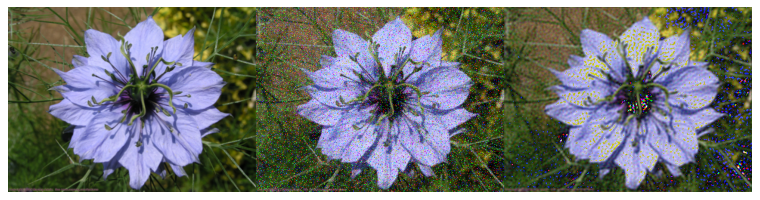

In [306]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,img1_deg,np.array(d1,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [276]:
d2 = deblurring_denoising(img1_deg, gamma = 2, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 15000)

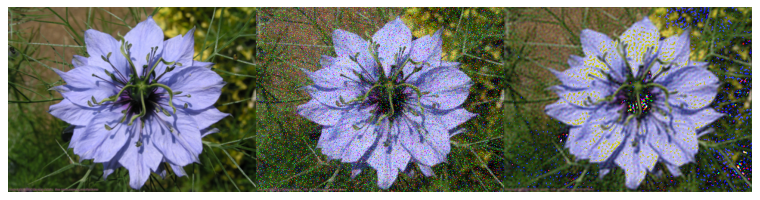

In [307]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,img1_deg,np.array(d2,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [297]:
d3 = deblurring_denoising(img1_deg, gamma = 10, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 15000)

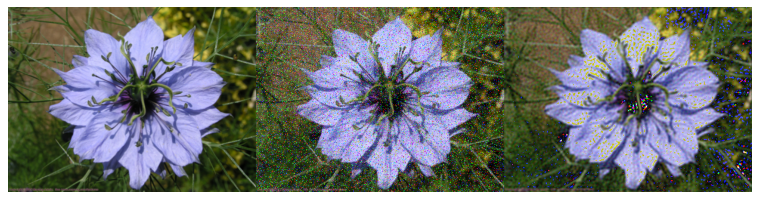

In [308]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,img1_deg,np.array(d3,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

Determinamos cual tenía el mejor PSNR

In [299]:
print("lambda = 0, PSNR = ",PSNR(np.array(d1,dtype=np.uint8),img))

print("lambda = 2, PSNR = ",PSNR(np.array(d2,dtype=np.uint8),img))

print("lambda = 10, PSNR = ",PSNR(np.array(d3,dtype=np.uint8),img))

lambda = 0, PSNR =  16.591339969799385
lambda = 2, PSNR =  16.756558745355573
lambda = 10, PSNR =  17.274397462087883


Por lo que el mejor PSNR lo obtenemos mediante lambda = 10.

### 3. Eliminación de ruido de impulso

1. Escribe una aproximación diferenciable del funcional en,

$$
argmax_u ~ E(u) = argmax_u \int_{\Omega} || u(x) -u_0(x)|| + \gamma || \nabla u(x) || dx
$$

y calcula su gradiente. 

Sol: Primero, la aproximación diferencial del funcional $E(u)$ que vamos a usar es,

$$
    E_{\eta}(u) = \int_{\Omega} \sqrt{\eta + || u(x) -u_0(x)||^2} + \gamma \sqrt{\eta + || \nabla u(x) ||^2} dx
$$

donde $\eta$ es un valor muy pequeño. Procedemos a calcular el gradiente realizando primero lo siguiente:

\begin{equation} \label{eq1}
\begin{split}
E_{\eta}(u+t\varphi) & = \int_{\Omega} \sqrt{\eta + || (u+t\varphi)(x) -u_0(x)||^2} + \gamma \sqrt{\eta + || \nabla (u+t\varphi)(x) ||^2} dx \\
     & = \int_{\Omega} \sqrt{\eta + || u(x) + t\varphi(x) -u_0(x)||^2} + \gamma \sqrt{\eta + || \nabla u(x) + t\nabla \varphi(x) ||^2} dx \\
     &= \int_{\Omega} \sqrt{\eta + || u(x) ||^2 + t^2|| \varphi(x)||^2 + ||u_0(x)||^2 + 2t<u(x),\varphi(x)> - 2<u(x),u_0(x)> - 2t<\varphi (x), u_0(x)>} + \gamma \sqrt{\eta + || \nabla u(x)||^2 + t^2|| \nabla \varphi(x) ||^2 + 2t <\nabla u(x),\nabla \varphi (x)>} dx 
\end{split}
\end{equation}

Ahora procedemos a calcular la derivada de t evaluada en cero:

\begin{equation} \label{eq2}
\begin{split}
\frac{dE_{\eta}(u+t\varphi)}{dt}|_0 &= \int_{\Omega} \frac{1}{2} \frac{2<u(x),\varphi (x)> -2<\varphi (x),u_0 (x) >}{\sqrt{\eta + ||u(x)||^2 + ||u_0(x)||^2 - 2<u(x),u_0(x)>}} + \frac{\gamma}{2} \frac{2<\nabla u(x),\nabla \varphi (x)>}{\sqrt{\eta + ||\nabla u(x) ||^2}} dx \\ 
    &= \int_{\Omega}  \frac{<u(x),\varphi (x)> -<\varphi (x),u_0 (x) >}{\sqrt{\eta + (||u(x) - u_0(x)||)^2}} + \gamma \frac{<\nabla u(x),\nabla \varphi (x)>}{\sqrt{\eta + ||\nabla u(x) ||^2}} dx \\
    &= \int_{\Omega}  <\frac{u(x)-u_0(x)}{\sqrt{\eta + (||u(x) - u_0(x)||)^2}}, \varphi (x)> + \gamma <\frac{\nabla u(x)}{\sqrt{\eta + ||\nabla u(x) ||^2}}, \nabla \varphi(x)> dx \\ 
    &= \int_{\Omega}  <\frac{u(x)-u_0(x)}{\sqrt{\eta + (||u(x) - u_0(x)||)^2}}, \varphi (x)> - \gamma <div \left( \frac{\nabla u(x)}{\sqrt{\eta + ||\nabla u(x) ||^2}} \right), \varphi(x)> dx \\
    &=  \int_{\Omega}  <\frac{u(x)-u_0(x)}{\sqrt{\eta + (||u(x) - u_0(x)||)^2}} - \gamma div \left( \frac{\nabla u(x)}{\sqrt{\eta + ||\nabla u(x) ||^2}} \right), \varphi (x)> dx \\
\end{split}
\end{equation}


Por un teorema visto en clase sabemos que 
$$\frac{dE_{\eta}(u+t\varphi)}{dt}|_0 = <\nabla E(u),\varphi>$$

De este modo igualando lo anterior,

$$
 <\nabla E(u),\varphi> = \int_{\Omega}  <\frac{u(x)-u_0(x)}{\sqrt{\eta + (||u(x) - u_0(x)||)^2}} - \gamma div \left( \frac{\nabla u(x)}{\sqrt{\eta + ||\nabla u(x) ||^2}} \right), \varphi (x)> dx =  <\frac{u-u_0}{\sqrt{\eta + (||u - u_0||)^2}} - \gamma div \left( \frac{\nabla u}{\sqrt{\eta + ||\nabla u ||^2}} \right), \varphi > 
$$

Y como lo anterior se cumple para toda $\varphi$ concluimos que,

$$
\nabla E(u) = \frac{u-u_0}{\sqrt{\eta + (||u - u_0||)^2}} - \gamma div \left( \frac{\nabla u}{\sqrt{\eta + ||\nabla u ||^2}} \right)
$$

In [312]:
def denoising(u , gamma, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 1000):
    u0 = u
    u1 = u
    
    for k in range(K):
        grad = gradient(u0)
        norm = norma(grad)
        den = np.sqrt(norm**2 + eta)
        grad = grad/den
        div = divergence(grad)
        
        norm1 = norma(u0-u)
        den1 = np.sqrt(norm1**2 + eta)
        A = (u0-u)/den1
        
        u1 = u0 - alpha*(A - gamma*div)
        
        if np.sqrt(MSE(u1,u0)) < eps:
            break
        
        u0 = u1
        
    return u1

In [304]:
img1_deg2 = cv2.imread("img1_degradation2.png")
img1_deg2 = cv2.cvtColor(img1_deg2, cv2.COLOR_BGR2RGB)

In [305]:
d4 = denoising(img1_deg2 , gamma = 1, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 15000)

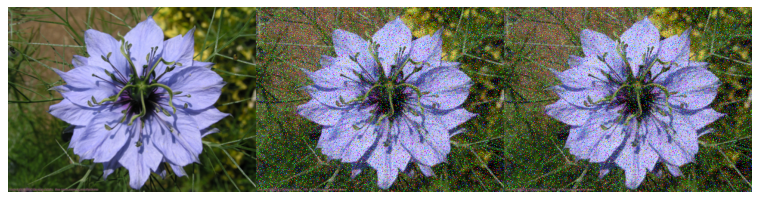

In [309]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,img1_deg2,np.array(d4,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [310]:
print("lambda = 1, PSNR = ",PSNR(np.array(d4,dtype=np.uint8),img))

lambda = 1, PSNR =  14.811957842998236


Vamos a probar ahora el algoritmo 2

In [313]:
def denoising2(u , gamma, eps = 0.001, eta = 0.0001, alpha = 0.01, K = 1000):
    u0 = u
    u1 = u
    
    for k in range(K):
        grad = gradient(u0)
        norm = norma(grad)
        den = np.sqrt(norm**2 + eta)
        grad = grad/den
        div = divergence(grad)
        
        A = u0-u
        
        u1 = u0 - alpha*(A - gamma*div)
        
        if np.sqrt(MSE(u1,u0)) < eps:
            break
        
        u0 = u1
        
    return u1

In [315]:
d5 = denoising2(img1_deg2 , gamma = 100, eps = 0.001, eta = 0.0001, alpha = 0.0001, K = 1000)

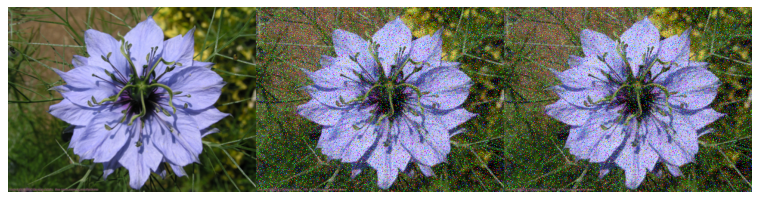

In [316]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(np.concatenate( (img,img1_deg2,np.array(d5,dtype=np.uint8)), axis = 1 ))
plt.axis('off')
plt.show()

In [317]:
print("lambda = 1, PSNR = ",PSNR(np.array(d5,dtype=np.uint8),img))

lambda = 1, PSNR =  14.811957842998236


In [318]:
diff = np.abs(PSNR(np.array(d5,dtype=np.uint8),img) - PSNR(np.array(d4,dtype=np.uint8),img))

In [320]:
print("Diferencia: ", diff)

Diferencia:  0.0


Por lo que según nuestros experimentos ambos modelos nos dan el mismo valor de PSNR, porque lo que son igual de beunos para el trabajo de eliminación de impulso de ruido. 

### 4. Procesamiento de contraste 

Para calcular el gradiente primero vamos a calcular lo siguiente:

\begin{equation} \label{eq1}
\begin{split}
E_{\eta}(u+t\varphi) & = \int_{\Omega} \frac{1}{2} ||(u+t \varphi)(x) - u_0(x) ||^2 dx - \frac{\gamma}{4} \int_{\Omega} \int_{\Omega} w(x-y) || (u+t\varphi)(x) - (u+t\varphi)(y)||^2 dx dy \\
    &= \frac{1}{2} \int_{\Omega} ||u(x)+t \varphi(x) - u_0(x) ||^2 dx - \frac{\gamma}{4} \int_{\Omega} \int_{\Omega} w(x-y) || u(x)+t\varphi(x) - u(y) - t\varphi(y)||^2 dx dy \\
    &= \frac{1}{2} \int_{\Omega} ||u(x)||^2 +t^2||\varphi(x)||^2 + ||u_0(x)||^2 + 2t<u(x),\varphi(x)> -2<u(x),u_0(x)> -2t<\varphi(x), u_0(x)> dx - \frac{\gamma}{4} \int_{\Omega} \int_{\Omega} w(x-y) (|| u(x)||^2 +t^2 ||\varphi(x)||^2 + ||u(y)||^2 + t^2|| \varphi(y)||^2 +2t<u(x),\varphi(x)> -2<u(x),u(x)> - 2t<u(x),\varphi(y)> -2t<\varphi (x),u(y)> +2t^2<\varphi(x), \varphi (y)>) +2t<u(y),\varphi(y)> dx dy \\
\end{split}
\end{equation}

Con esto prosigamos a calcular la derivada con respecto a t y evaluada en cero,


\begin{equation} \label{eq2}
\begin{split}
\frac{dE_{\eta}(u+t\varphi)}{dt}|_0 &=  \frac{1}{2} \int_{\Omega} 2<u(x),\varphi(x)> -2<\varphi(x),u_0(x)>dx - \frac{\gamma}{4} \int_{\Omega} \int_{\Omega} w(x-y) (2<u(x),\varphi(x)> -2<u(x),\varphi(y)> -2<\varphi(x),u(y)> +2<u(y),\varphi(y)>) dx dy \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2} \int_{\Omega} \int_{\Omega} w(x-y) (<u(x),\varphi(x)> -<u(x),\varphi(y)> -<\varphi(x),u(y)> + <u(y),\varphi(y)>) dx dy \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2}( \int_{\Omega} \int_{\Omega} w(x-y) <u(x),\varphi(x)> -  \int_{\Omega} \int_{\Omega} w(x-y)<u(x),\varphi(y)> - \int_{\Omega} \int_{\Omega} w(x-y)<\varphi(x),u(y)> +  \int_{\Omega} \int_{\Omega} w(x-y)<u(y),\varphi(y)> dx dy ) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2}( \int_{\Omega} <u(x),\varphi(x)> \int_{\Omega} w(x-y) dydx  -  \int_{\Omega}  <\int_{\Omega} w(x-y)u(x)dx,\varphi(y)> dy - \int_{\Omega} <\int_{\Omega} w(x-y)u(y)dy,\varphi(x)>dx +  \int_{\Omega} <u(y),\varphi(y)> \int_{\Omega} w(x-y) dx dy ) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2}( \int_{\Omega} <u(x),\varphi(x)> \int_{\Omega} w(x-y) dydx  -  \int_{\Omega}  <\int_{\Omega} w(x-y)u(x)dx,\varphi(y)> dy - \int_{\Omega} <\int_{\Omega} w(x-y)u(y)dy,\varphi(x)>dx +  \int_{\Omega} <u(y),\varphi(y)> \int_{\Omega} w(x-y) dx dy ) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2}( \int_{\Omega} <u(x),\varphi(x)> dx  -  \int_{\Omega}  <w*u(y),\varphi(y)> dy - \int_{\Omega} <w*u(x),\varphi(x)>dx +  \int_{\Omega} <u(y),\varphi(y)> dy ) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \frac{\gamma}{2}( 2\int_{\Omega} <u(x),\varphi(x)> dx  -  2\int_{\Omega}  <w*u(y),\varphi(y)> dy) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \gamma( \int_{\Omega} <u(x),\varphi(x)> dx - \int_{\Omega}  <w*u(y),\varphi(y)> dy) \\
    &= \int_{\Omega} <u(x)-u_0(x),\varphi(x)> dx - \gamma( \int_{\Omega} <u(x)-w*u(x),\varphi(x)> dx) \\
    &= \int_{\Omega} <u(x)-u_0(x) - \gamma(u(x)-w*u(x)),\varphi(x)> dx \\
    &= <u-u_0 - \gamma(u-w*u),\varphi>
\end{split}
\end{equation}


Por un teorema visto en clase tenemos que,

$$
<\nabla E(u),\varphi> = <u-u_0 - \gamma(u-w*u),\varphi>
$$

Y como se cumple para toda $\varphi$ concluimos que

$$
\nabla E(u) = u-u_0 - \gamma(u-w*u)
$$

In [ ]:
#Me faltó el codigo:()